
# Description:
### The 1st assignment for the course of Practical Data Science 2024/2025 comprises two sections. Follow the next steps and submit a notebook (the output per cell should be visible), compressed, with the following name "f[ID].ipynb.zip", where [ID] is your student ID.

In [ ]:
# Part A
#### 1. Basic: Load the annotation files and compute the probability per emotion per annotator. Visualise it in a single plot.

In [1]:
!pip install openpyxl

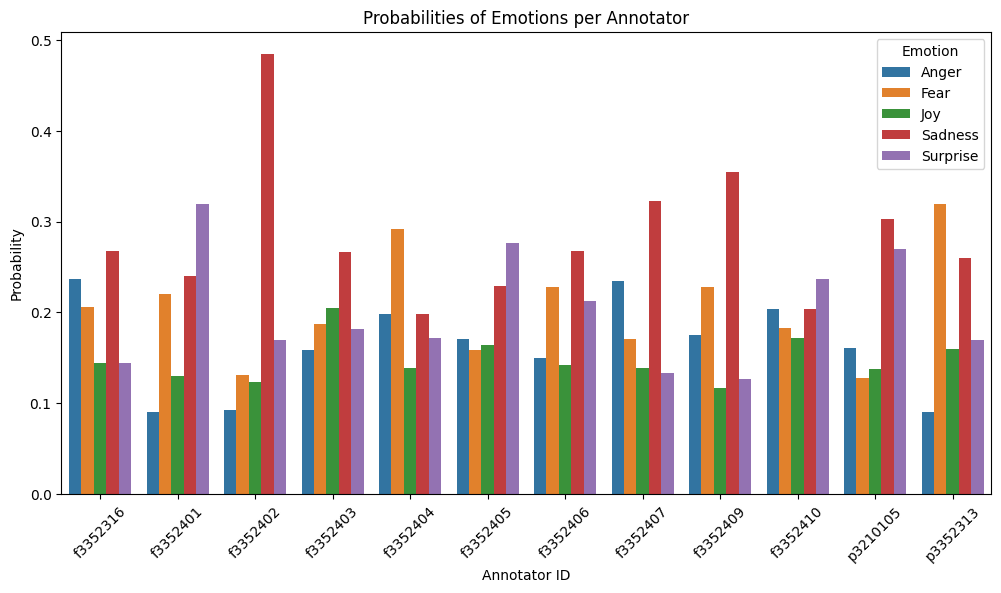

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# Folder path
folder_path = r'C:\Users\steli\OneDrive\Desktop\Stelios\DSAUEB\Trimester 1\PDS\Α1\Sentiment annotations'

#Loading files and compute probabilities using os library to browse into directories
combined_probabilities = pd.DataFrame()
#Loop into the directory and load each .xlsx into a dataframe 
for file in os.listdir(folder_path):
    if file.endswith('.xlsx'):
        annotator_id = file.split('.')[0]  # Extract annotator ID fro file name using split 
        df = pd.read_excel(os.path.join(folder_path, file), header=1)  # Load with header on line 2 to ignore commenting on line 1
        emotions = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
        """
        The probabilities are calculated for each emotion by dividing the total counts of each emotion by the sum of all counts across emotions. 
        The resulting probabilities will sum to 1 across all emotions. 
        In the previous exercise I was calculating each emotion's count by the total number of annotations (rows). 
        This led to probabilities that did not sum to 1 as multiple emotions were annotated in a single instance.
        So the best practice is to to normalize the probabilities based on total counts of emotions across all rows.
        """
        # Calculating total counts for each emotion
        total_counts = df[emotions].sum(axis=1)  # Sum counts for each emotion across rows
        emotion_sums = df[emotions].sum()  # Sum counts for each emotion across all rows

        # Computing probabilities
        probabilities = emotion_sums.div(emotion_sums.sum())  # Element-wise division to compute probabilities per emotion
        probabilities = probabilities.to_frame().T  # Converting to DataFrame and transposing
        probabilities['Annotator'] = annotator_id  # Adding the annotator ID

        # Combine the current probabilities with the main DataFrame
        combined_probabilities = pd.concat([combined_probabilities, probabilities], ignore_index=True)

#print(combined_probabilities)

# Reshape the DataFrame for easier plotting
"""
By using melt function transforms the DataFrame 
into a long format suitable for plotting. This way each variable is stacked into a single column, 
which makes it easier to plot categorical data. Now, each row represents a single emotion probability for an annotator.
"""
combined_probabilities_melted = combined_probabilities.melt(id_vars='Annotator', 
                                                              var_name='Emotion', 
                                                              value_name='Probability')
#print(combined_probabilities_melted)

# Visualizing
plt.figure(figsize=(12, 6))

# Create a bar plot
sns.barplot(data=combined_probabilities_melted, 
            x='Annotator', 
            y='Probability', 
            hue='Emotion')

# Adding titles and labels
plt.title('Probabilities of Emotions per Annotator')
plt.xlabel('Annotator ID')
plt.ylabel('Probability')
plt.legend(title='Emotion')

# Show the plot
plt.xticks(rotation=45)
plt.show()

#### Explanation :
The figure displays the probability distribution of five different emotions (Anger, Fear, Joy, Sadness, and Surprise) as rated by various annotator. Each annotators work is represented by five bars one for each emotion. 
#### Some insights are: 
Sadness (red bars) have higher probabilities for most annotators, particularly for f352402, f352407, and f352409.
Fear (orange bars) has also significant probability, particularly for annotators like f352401, f352403, f352404, and p335213. In some cases, the probability of Fear exceeds Sadness.

Emotions like Joy (green) and Anger (blue) generally have lower probabilities compared to Sadness and Fear.
Specifically, Joy (green bars) generally has lower probabilities across all annotators. This may imply that the dataset being evaluated is skewed toward negative emotions, or that Joy is less apparent to the annotators.
Surprise (purple bars) appears with moderate probabilities for most annotators, often close to the levels of Fear or Joy.
Anger (blue bars) generally has low probabilities, with only a few annotators like f352316 and f352407 assigning higher values.

In general,there is a notable variance between annotators. For instance, some annotators like f352405 and p3210105 show more balance across emotions, with no single emotion dominating. In contrast, f352402 and f352407 have highly skewed distributions, favoring Sadness and Fear.
This variation suggests that different annotators might have diverse perceptions or biases when interpreting the emotional content.

# 2. IAA: Compute the pairwise inter-annotator agreement, using both Cohen's kappa and percentage agreeemnt. Compare the two and discuss any differences. Visualise the best of the two using a table of agreement with a heatmap.
According to the definitions of the metrics, 

**Percentage Agreement**: measures the proportion of times annotators agreed, offering a simple view of agreement levels but without adjusting for chance agreement.

**Cohen's Kappa** adjusts for chance, providing a more accurate measure of true agreement, especially useful for imbalanced classes where chance agreement could otherwise inflate the scores.



## Overall Agreement
In this case I chose to calculate overall agreement metrics because they provide a quick view of how well annotators agree across all emotions. This approach is easy to understand and saves time, making it great for initial assessments.It aggregates the results into two matrices (pairwise_kappa and pairwise_percentage) which represent the average agreement across all emotions.

### Percentage Agreement:
```
agree_counts = (data1.values == data2.values).sum(axis=1)  # Count of agreements per emotion
total_counts = data1.shape[1]  # Total number of emotions
percentage_agreement = (agree_counts == total_counts).mean()  
```
### Cohen's Kappa 
```
kappa_scores = [cohen_kappa_score(data1[emotion], data2[emotion]) for emotion in data1.columns]
avg_kappa = sum(kappa_scores) / len(kappa_scores)

```

Average Kappa is: 0.38 Average percentage is: 0.32


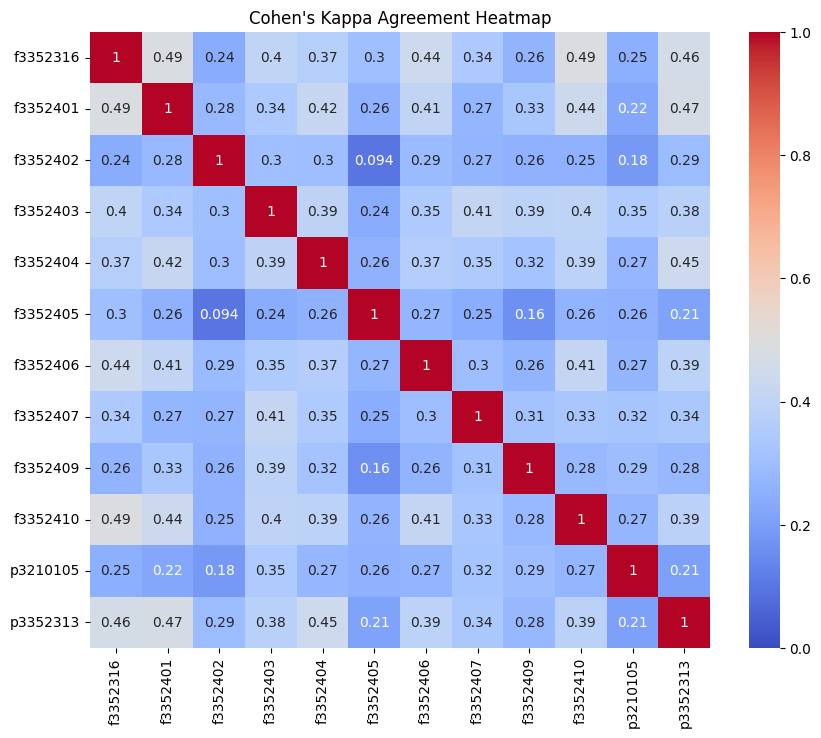

In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import numpy as np

# Load data and compute pairwise agreement
annotator_data = {}  # Dictionary to load each Excel file into for each annotator

# Loop through files in the specified folder
for file in os.listdir(folder_path):
    # Check if the file is an Excel file
    if file.endswith('.xlsx'):
        # Extract annotator ID from the filename
        annotator_id = file.split('.')[0]
        # Load the relevant columns from the Excel file into a DataFrame
        df = pd.read_excel(os.path.join(folder_path, file), header=1)
        annotator_data[annotator_id] = df[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

# Initialize DataFrames to store pairwise kappa and percentage agreements
annotators = list(annotator_data.keys())
pairwise_kappa = pd.DataFrame(index=annotators, columns=annotators)  # Kappa scores matrix
pairwise_percentage = pd.DataFrame(index=annotators, columns=annotators)  # Percentage agreement matrix

# Compute pairwise agreements for each pair of annotators
for i in range(len(annotators)):
    for j in range(i, len(annotators)):
        annotator1 = annotators[i]
        annotator2 = annotators[j]

        """
        In our dataset, there are some missing values eg. 
        (file f3352404 cell f56 ,file f3352404 file f3352406 row 60)
        """
        data1 = annotator_data[annotator1]  # Data for the first annotator
        data1 = data1.fillna(0)  # Replace NaN values with 0
        data2 = annotator_data[annotator2]  # Data for the second annotator
        data2 = data2.fillna(0)  # Replace NaN values with 0
        
        # Calculate Percentage Agreement
        # Count the number of agreements for each emotion
        agree_counts = (data1.values == data2.values).sum(axis=1)  # Count of agreements per emotion
        total_counts = data1.shape[1]  # Total number of emotions
        # Compute the mean percentage agreement
        percentage_agreement = (agree_counts == total_counts).mean()  
        # Store the percentage agreement results symmetrically in the DataFrame
        pairwise_percentage.loc[annotator1, annotator2] = percentage_agreement
        pairwise_percentage.loc[annotator2, annotator1] = percentage_agreement

        # Calculate Cohen's Kappa for the emotions
        # Compute kappa scores for each emotion and average them
        kappa_scores = [cohen_kappa_score(data1[emotion], data2[emotion]) for emotion in data1.columns]
        avg_kappa = sum(kappa_scores) / len(kappa_scores)  # Average kappa score
        # Store the average kappa results symmetrically in the DataFrame
        pairwise_kappa.loc[annotator1, annotator2] = avg_kappa
        pairwise_kappa.loc[annotator2, annotator1] = avg_kappa

#  kappa and percentage agreement  to float for better display
pairwise_kappa = pairwise_kappa.astype(float)
pairwise_percentage = pairwise_percentage.astype(float)

# saverage scores for kappa and percentage agreement
avg_kappa = pairwise_kappa.values.mean()  # Average Kappa score across all pairs
avg_percentage = pairwise_percentage.values.mean()  # Average percentage agreement across all pairs
print(f"Average Kappa is: {round(avg_kappa, 2)} Average percentage is: {round(avg_percentage, 2)}")

# Heatmap for Cohen's Kappa agreement
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_kappa, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title('Cohen\'s Kappa Agreement Heatmap')
plt.show()




## Per-Emotion Agreement
I opted for per-emotion agreement metrics to get a clearer picture of how annotators agree on each specific emotion. This method helps identify which emotions have more disagreement, allowing for targeted improvements in the annotation process. It provides useful insights into the quality of emotional assessments.

Each emotion has its own Kappa and percentage agreement calculated independently, allowing for a more granular analysis of the agreement levels for specific emotions.

### Percentage Agreement:
```
for emotion in data1.columns:
    percentage_agreement = (data1[emotion].values == data2[emotion].values).mean()  
 
```
### Cohen's Kappa 
```
kappa_score = cohen_kappa_score(data1[emotion], data2[emotion])


```

In [4]:
#dictionaries to store pairwise results for each emotion
pairwise_kappa_per_emotion = {emotion: pd.DataFrame(index=annotator_data.keys(), columns=annotator_data.keys()) 
                              for emotion in annotator_data[annotator_id].columns}
pairwise_percentage_per_emotion = {emotion: pd.DataFrame(index=annotator_data.keys(), columns=annotator_data.keys()) 
                                   for emotion in annotator_data[annotator_id].columns}

# List of annotator IDs for iterating through pairs
annotators = list(annotator_data.keys())
for i in range(len(annotators)):
    for j in range(i, len(annotators)):
        annotator1 = annotators[i]
        annotator2 = annotators[j]

        # Fill null values with zero in data from each annotator
        data1 = annotator_data[annotator1].fillna(0)
        data2 = annotator_data[annotator2].fillna(0)

        for emotion in data1.columns:
            # Percentage Agreement for the current emotion
            percentage_agreement = (data1[emotion].values == data2[emotion].values).mean()
            pairwise_percentage_per_emotion[emotion].loc[annotator1, annotator2] = percentage_agreement
            pairwise_percentage_per_emotion[emotion].loc[annotator2, annotator1] = percentage_agreement

            # Cohen's Kappa for the current emotion
            kappa_score = cohen_kappa_score(data1[emotion], data2[emotion])
            pairwise_kappa_per_emotion[emotion].loc[annotator1, annotator2] = kappa_score
            pairwise_kappa_per_emotion[emotion].loc[annotator2, annotator1] = kappa_score

# Convert metrics to float for better display in visualization
for emotion in pairwise_kappa_per_emotion:
    pairwise_kappa_per_emotion[emotion] = pairwise_kappa_per_emotion[emotion].astype(float)
    pairwise_percentage_per_emotion[emotion] = pairwise_percentage_per_emotion[emotion].astype(float)

# Calculate and print overall averages for Kappa and Percentage Agreement per emotion
avg_kappa = {emotion: pairwise_kappa_per_emotion[emotion].values.mean() for emotion in pairwise_kappa_per_emotion}
avg_percentage = {emotion: pairwise_percentage_per_emotion[emotion].values.mean() for emotion in pairwise_percentage_per_emotion}

print("Average Kappa per emotion:", {emotion: round(score, 2) for emotion, score in avg_kappa.items()})
print("Average Percentage Agreement per emotion:", {emotion: round(score, 2) for emotion, score in avg_percentage.items()})

Average Kappa per emotion: {'Anger': np.float64(0.35), 'Fear': np.float64(0.33), 'Joy': np.float64(0.49), 'Sadness': np.float64(0.39), 'Surprise': np.float64(0.33)}
Average Percentage Agreement per emotion: {'Anger': np.float64(0.79), 'Fear': np.float64(0.75), 'Joy': np.float64(0.85), 'Sadness': np.float64(0.71), 'Surprise': np.float64(0.74)}


Overall, the percentage agreement scores are higher than the Kappa scores, which suggests that annotators often agree, but this agreement might not be reliable.

Among all emotions, Joy and Sadness are the two best in terms of inter-annotator agreement metrics. Joy is the highest average Kappa score of 0.49, indicating agreement when accounting for chance, along with a high percentage agreement of 85%, meaning strong consensus among annotators. Following closely, Sadness has an average Kappa score of 0.39 and a percentage agreement of 71%. While not as high as Joy's scores, Sadness still reflects a reasonable level of agreement and reliability. Together, these two emotions demonstrate better annotator consistency and agreement compared toall the other emotions, suggesting they are classified more accurately and reliably in the dataset.

In summary, high percentage agreement scores suggest that annotators align often, but lower Kappa scores raise concerns about reliability.

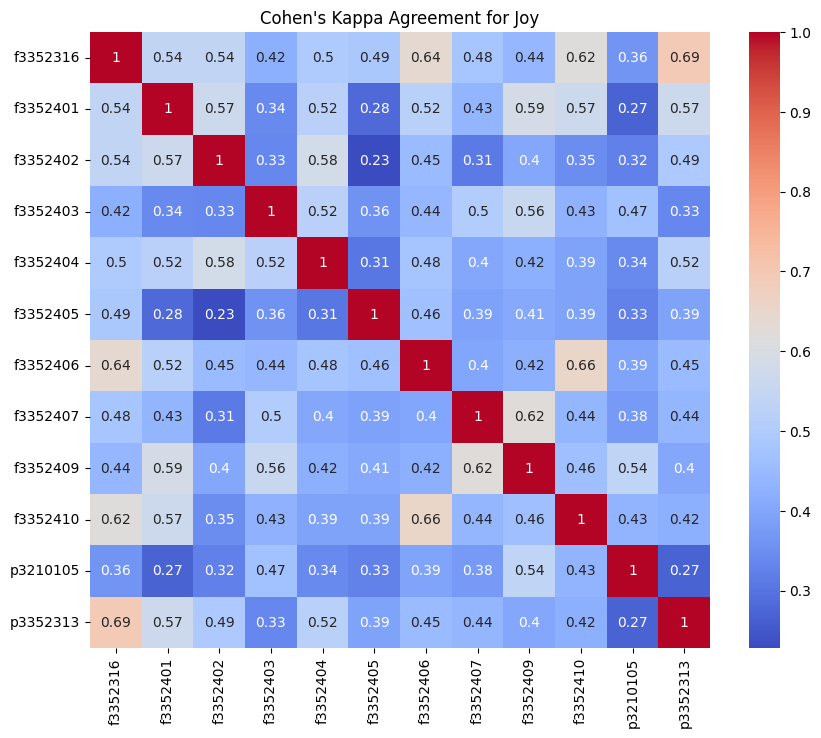

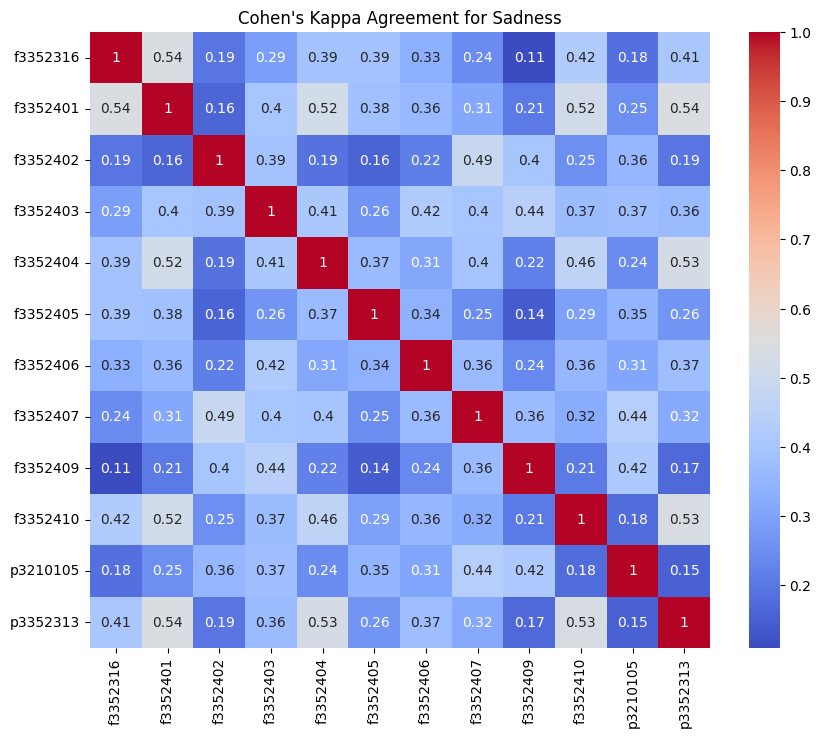

In [5]:
# Visualizing pairwise kappa and percentage agreements for Joy and Sadness
for emotion in ["Joy", "Sadness"]:
    # Heatmap for Cohen's Kappa agreement
    plt.figure(figsize=(10, 8))
    sns.heatmap(pairwise_kappa_per_emotion[emotion], annot=True, cmap="coolwarm")
    plt.title(f'Cohen\'s Kappa Agreement for {emotion}')
    plt.show()




# 3. Ground-truth: Compute a ground truth value per emotion per text (e.g., using a majority vote).

In [6]:
import pandas as pd

# Initialize a DataFrame for ground truth
ground_truth = pd.DataFrame()

# List of emotions to consider
emotions = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

#  ground truth using majority voting
for emotion in emotions:
    # Stack all annotations for the current emotion
    stacked_data = pd.concat([annotator_data[annotator][emotion] for annotator in annotator_data.keys()], axis=1)
    # Determine majority vote for each row
    ground_truth[emotion] = stacked_data.mode(axis=1)[0]  # The mode gives the most frequent value



print(ground_truth)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

     Anger  Fear  Joy  Sadness  Surprise
0      0.0   1.0  0.0      0.0       1.0
1      0.0   0.0  0.0      0.0       0.0
2      0.0   0.0  0.0      0.0       1.0
3      0.0   0.0  0.0      1.0       0.0
4      0.0   0.0  0.0      0.0       0.0
..     ...   ...  ...      ...       ...
111    1.0   0.0  0.0      0.0       0.0
112    0.0   0.0  0.0      0.0       1.0
113    0.0   0.0  0.0      1.0       0.0
114    0.0   0.0  0.0      1.0       0.0
115    0.0   0.0  0.0      0.0       0.0

[116 rows x 5 columns]


The presence of multiple 1 values for different emotions in a single row of the ground_truth DataFrame indicates that the majority vote for those particular emotions was agreed by the annotators for that specific instance. In other words, if several annotators recognize multiple emotions for an instance, those emotions will be reflected in the ground truth. For example, if three out of five annotators identified Fear and Surprise, both would be recorded as 1

# 4. LLMs: Prompt an open-source large language model (LLM), such as the Llama-3-8b-instruct (quantized) that we used in class to annotate each text for existing emotions.

In this part, we're creating a blank_df by erasing the annotations in order to be annotated by the LLM.

In [7]:
# Copy of the original DataFrame
blank_df = df.copy()


blank_df.drop(columns=["id"], inplace=True)

# emotions to consider
emotions = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

# Iterating over each emotion in the list
for emotion in emotions:
    # Adding a new column for each emotion and setting its contents to empty strings
    blank_df[emotion] = ""

blank_df

,text,Anger,Fear,Joy,Sadness,Surprise
0,"My mouth fell open `` No, no, no... I..",,,,,
1,You can barely make out your daughter's pale f...,,,,,
2,But after blinking my eyes for a few times lep...,,,,,
3,Slowly rising to my feet I came to the conclus...,,,,,
4,I noticed this months after moving in and doin...,,,,,
...,...,...,...,...,...,...
111,"""ARcH stop your progression.",,,,,
112,"This 'star', starts to move across the sky.",,,,,
113,and my feet hurt.,,,,,
114,so i cried my eyes out and did the drawing.,,,,,


Below is a simpler case of annotation without socioodemographic for the llama model it is currently marked as comments for time saving as the same function is used for a mores instructed prompting.

In [8]:

import pandas as pd
import ollama
import re

def annotate_emotions(text):
    # Generate text using ollama with the desired prompt
    prompt = (f"Analyze the following text for emotions (Anger, Fear, Joy, Sadness, Surprise):\n"
                f"\"{text}\"\n"
                f"Return a binary output (0 or 1) for each emotion without explanations.")

    
    # Call ollama.generate to get the response
    response = ollama.generate(model='llama3.2', prompt=prompt)
    
    # Access the text content within the response dictionary
    response_text = response["response"]  # Adjust if necessary
    
    # dictionary to hold emotion values
    emotion_dict = {'Anger': 0, 'Fear': 0, 'Joy': 0, 'Sadness': 0, 'Surprise': 0}
    
    
    #[-*]?: Matches an optional '-' or '*' at the start.
    #\s*: Matches any whitespace (space, tab, etc.) zero or more times.
    #(\w+): Matches one or more word characters (letters, digits, or underscores) and captures them in a group.
    #:: Matches a literal colon.
    #\s*: Matches any whitespace zero or more times.
    #(\d+(?:\.\d+)?): Matches a number (one or more digits). 
    
    emotion_lines = re.findall(r"[-*]?\s*(\w+):\s*(\d+(?:\.\d+)?)", response_text) #findall to emotions annotations in the text

    # Updating emotion_dict based on the found lines
    for key, value in emotion_lines:
        key = key.strip()  # Clean up the key
        value = float(value)  # Convert value to float
        if key in emotion_dict and (value == 0 or value == 1):  # Ensure value is binary
            emotion_dict[key] = int(value)  # Set binary output directly

    return emotion_dict

# annotations dataframe
annotated_df = blank_df.copy()


for index, row in blank_df.iterrows():
    emotions = annotate_emotions(row['text'])# annotating function with llama
    print(f"Text: {row['text']}\n")
    print(f"Emotions: {emotions}\n")
 
    # Store the results in the annotated_df DataFrame
    annotated_df.at[index, 'Anger'] = emotions.get('Anger', 0)
    annotated_df.at[index, 'Fear'] = emotions.get('Fear', 0)
    annotated_df.at[index, 'Joy'] = emotions.get('Joy', 0)
    annotated_df.at[index, 'Sadness'] = emotions.get('Sadness', 0)
    annotated_df.at[index, 'Surprise'] = emotions.get('Surprise', 0)

# annotated DataFrame
print(annotated_df)


Text: My mouth fell open `` No, no, no... I..

Emotions: {'Anger': 0, 'Fear': 0, 'Joy': 0, 'Sadness': 0, 'Surprise': 1}

Text: You can barely make out your daughter's pale form in the darkness of your room.

Emotions: {'Anger': 0, 'Fear': 1, 'Joy': 0, 'Sadness': 1, 'Surprise': 0}

Text: But after blinking my eyes for a few times lepas tu tampar-tampar muka sikit, memang sah la yang penghantar itu Hanis Zalikha.

Emotions: {'Anger': 0, 'Fear': 0, 'Joy': 0, 'Sadness': 0, 'Surprise': 1}

Text: Slowly rising to my feet I came to the conclusion that sometimes being alone meant surviving for myself.

Emotions: {'Anger': 0, 'Fear': 0, 'Joy': 0, 'Sadness': 0, 'Surprise': 0}

Text: I noticed this months after moving in and doing all of my basic routines in my room naked.

Emotions: {'Anger': 0, 'Fear': 0, 'Joy': 0, 'Sadness': 0, 'Surprise': 1}

Text: I know not why, I wipe my face.

Emotions: {'Anger': 0, 'Fear': 0, 'Joy': 0, 'Sadness': 0, 'Surprise': 1}

Text: It was rather insulting.

Emotion

## Agents: Instructing the LLM to have a different sociodemographic background before annotating. For instance, using gender, instruct the LLM to be a man and then to be a woman. Compare the two sets of annotations and quantify how much does the background affects the model's decisions. Compute the IAA between the agents and the human annotators. Discuss the outcomes.

In [9]:
import pandas as pd
import ollama
import re

def annotate_emotions_instructed(text, gender,age,region):
    # Generate text using ollama with the desired prompt
    prompt = (f"Analyze the following text\n"
              f" << \"{text}\" >> for emotions (Anger, Fear, Joy, Sadness, Surprise) \n" 
              f"considering you think like a: {age} years old {gender} from {region}.\n"
              f"Return a binary output (0 or 1) for each emotion without explanations.")
    #print(prompt)
    # Call ollama.generate to get the response
    response = ollama.generate(model='llama3.2', prompt=prompt)
    
    # Access the text content within the response dictionary
    response_text = response["response"]  # Adjust if necessary
    
    # Dictionary to hold emotion values
    emotion_dict = {'Anger': 0, 'Fear': 0, 'Joy': 0, 'Sadness': 0, 'Surprise': 0}


    #[-*]?: Matches an optional '-' or '*' at the start.
    #\s*: Matches any whitespace (space, tab, etc.) zero or more times.
    #(\w+): Matches one or more word characters (letters, digits, or underscores) and captures them in a group.
    #:: Matches a literal colon.
    #\s*: Matches any whitespace zero or more times.
    #(\d+(?:\.\d+)?): Matches a number (one or more digits). 
    

    # Find emotion annotations in the response text based on the formatting I asked for
    emotion_lines = re.findall(r"[-*]?\s*(\w+):\s*(\d+(?:\.\d+)?)", response_text)

    # Updating emotion_dict based on the found lines
    for key, value in emotion_lines:
        key = key.strip()  # Clean up the key
        value = float(value)  # Convert value to float
        if key in emotion_dict and (value == 0 or value == 1):  # Ensure value is binary
            emotion_dict[key] = int(value)  # Set binary output directly

    return emotion_dict



# Different annotator dfs
annotated_df_male = pd.DataFrame(columns=['Text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])
annotated_df_female = pd.DataFrame(columns=['Text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])

for index, row in blank_df.iterrows():
    # Annotate for Male Child
    emotions_male = annotate_emotions_instructed(row['text'], '17','male','New York')
    
    # Annotate for Female adult
    emotions_female = annotate_emotions_instructed(row['text'],'56', 'female','Russia')

    
    print(f"Text : {row['text']}\n")
    #print(f"Emotions (Male Child): {emotions_male}\n")
    #print(f"Emotions (Female adult): {emotions_female}\n")

    # Store the results in the annotated_df_male DataFrame using .at[]
    annotated_df_male.at[index, 'Text'] = row['text']
    annotated_df_male.at[index, 'Anger'] = emotions_male.get('Anger', 0)
    annotated_df_male.at[index, 'Fear'] = emotions_male.get('Fear', 0)
    annotated_df_male.at[index, 'Joy'] = emotions_male.get('Joy', 0)
    annotated_df_male.at[index, 'Sadness'] = emotions_male.get('Sadness', 0)
    annotated_df_male.at[index, 'Surprise'] = emotions_male.get('Surprise', 0)

    # Store the results in the annotated_df_female DataFrame using .at[]
    annotated_df_female.at[index, 'Text'] = row['text']
    annotated_df_female.at[index, 'Anger'] = emotions_female.get('Anger', 0)
    annotated_df_female.at[index, 'Fear'] = emotions_female.get('Fear', 0)
    annotated_df_female.at[index, 'Joy'] = emotions_female.get('Joy', 0)
    annotated_df_female.at[index, 'Sadness'] = emotions_female.get('Sadness', 0)
    annotated_df_female.at[index, 'Surprise'] = emotions_female.get('Surprise', 0)

# annotated DataFrames
print("Annotated Emotions for Male Child:")
print(annotated_df_male)

print("\nAnnotated Emotions for Female adult:")
print(annotated_df_female)


Text : My mouth fell open `` No, no, no... I..

Text : You can barely make out your daughter's pale form in the darkness of your room.

Text : But after blinking my eyes for a few times lepas tu tampar-tampar muka sikit, memang sah la yang penghantar itu Hanis Zalikha.

Text : Slowly rising to my feet I came to the conclusion that sometimes being alone meant surviving for myself.

Text : I noticed this months after moving in and doing all of my basic routines in my room naked.

Text : I know not why, I wipe my face.

Text : It was rather insulting.

Text : I was born without the compassion chromosome, or I could have been born with two hearts, neither one agreeing where my brain should spend it's time.

Text : ; ) In the evening we did go down and put our feet in the water-I got to about my waist actually.

Text : I feel like I am in over my head... Like Quicksand.

Text : I would go over to his house where his Grandmother and mom and dad lived to play SSX Tricky and eat Pokemon fruit 

In [17]:

# Save DataFrames to Excel without row indices
annotated_df_male.to_excel('C:/Users/steli/OneDrive/Desktop/Stelios/DSAUEB/Trimester 1/PDS/Α1/Sentiment annotations/Annotated_Emotions_male.xlsx', index=False)
annotated_df_female.to_excel('C:/Users/steli/OneDrive/Desktop/Stelios/DSAUEB/Trimester 1/PDS/Α1/Sentiment annotations/Annotated_Emotions_female.xlsx', index=False)


Now after the annotation of the two differently "instructed llama annotators" it's time to visualise their annotations in order to compare the two sets of annotations and quantify how much does the background affects the model's decisions 

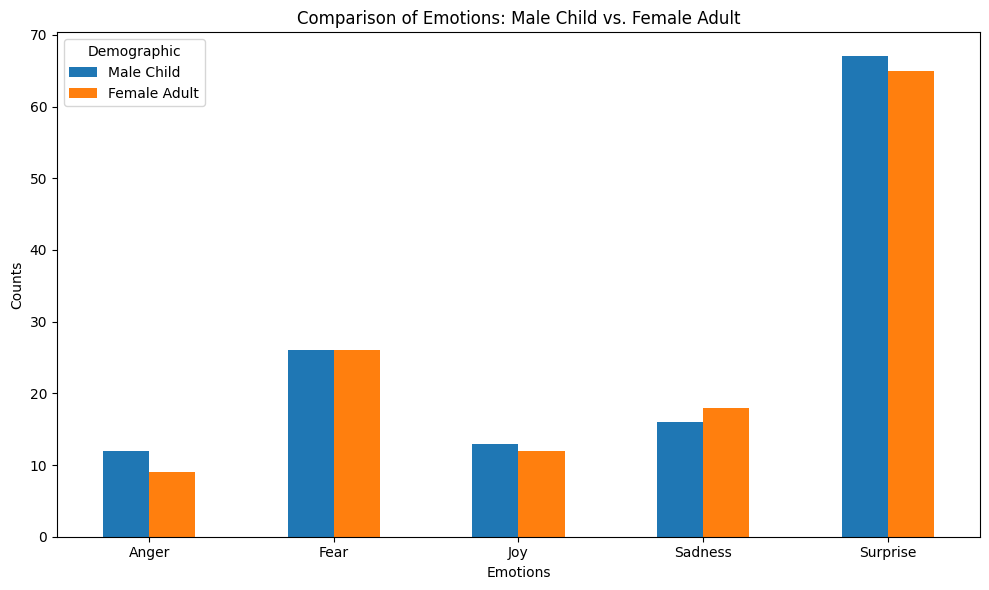

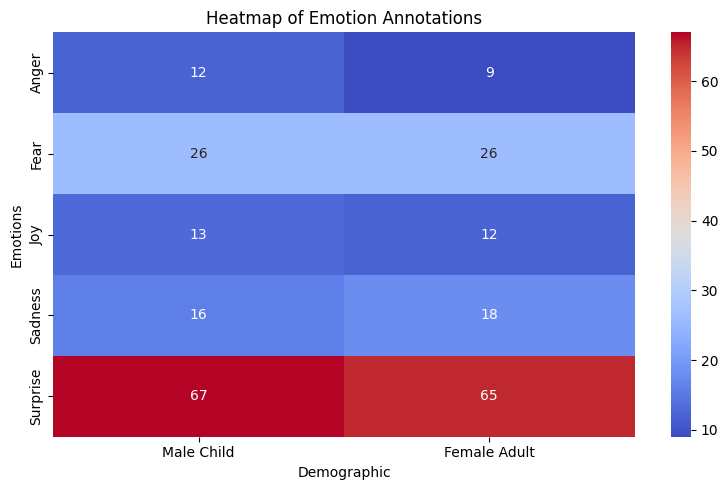

In [11]:
# comparison DataFrame
comparison_df = pd.DataFrame({
    'Emotion': ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'],
    'Male Child': annotated_df_male[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].sum().values,
    'Female Adult': annotated_df_female[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].sum().values
})

# Ensure the counts are numeric
comparison_df[['Male Child', 'Female Adult']] = comparison_df[['Male Child', 'Female Adult']].apply(pd.to_numeric)

# Visualization: Bar Chart
comparison_df.set_index('Emotion').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Emotions: Male Child vs. Female Adult')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.legend(title='Demographic')
plt.tight_layout()
plt.show()

# Visualization: Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(comparison_df.set_index('Emotion'), annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Emotion Annotations')
plt.xlabel('Demographic')
plt.ylabel('Emotions')
plt.tight_layout()
plt.show()


In [12]:
comparison_df

,Emotion,Male Child,Female Adult
0,Anger,12,9
1,Fear,26,26
2,Joy,13,12
3,Sadness,16,18
4,Surprise,67,65


In [13]:
# Calculate Relative Differences
comparison_df['Percentage Difference'] = (
    (comparison_df['Female Adult'] - comparison_df['Male Child']) / 
    comparison_df['Male Child'] * 100
)
print(f"{comparison_df[['Emotion', 'Percentage Difference']]}]\n")


from scipy.stats import chi2_contingency

# Prepare data for the chi-square test
observed = comparison_df[['Male Child', 'Female Adult']].values.T  # Transpose to match required shape

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(observed)

# Print results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")


    Emotion  Percentage Difference
0     Anger             -25.000000
1      Fear               0.000000
2       Joy              -7.692308
3   Sadness              12.500000
4  Surprise              -2.985075]

Chi-Square Statistic: 0.5560431070246703
P-Value: 0.9678208001393466


**Emotion Percentage Difference**

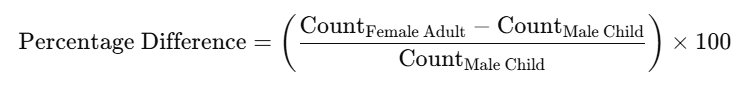

Percentage agreement measures how much the count of emotions differs between Female Adult and Male Child, expressed as a percentage of the count for Male Child.

**Anger: -25%**

The female adult reported a lower incidence of anger compared to the male child by about 25%. This may indicate that the male teen from New York perceives or expresses anger more frequently than the female adult.

**Fear: 0%**

There is no difference between the counts of Female Adult and Male Child annotations for Fear. Both demographics have the same level of annotation for this emotion.

**Joy: -7.69%**

A significant decrease in joy annotations by the female adult compared to the male child indicates that the male child perceives or expresses joy more often. This could reflect differences in emotional responses related to age or gender.

**Sadness: 12.5%**

The female adult reported slightly more sadness (about 13 % higher) than the male child, indicating a higher tendency to express or perceive sadness in the adult context.

**Surprise: -2.99%**

The female adult showed a notable increase in surprise compared to the male child, indicating she is more likely to recognize or express surprise.

**Chi-Square Test Results** Chi-Square Statistic: 0.56 A measure of how much the observed counts deviate from the expected counts under the null hypothesis of independence.

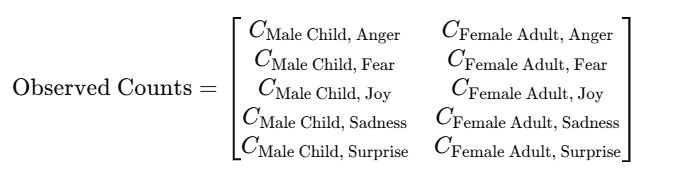
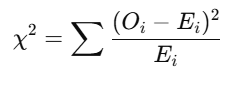

The Chi-Square Statistic of 0.56 suggests a low degree of association between the emotions of the 17 years old male from New York and 56 years old female from Russia.

**P-Value: 0.9678**
The P-Value of 0.9678 is significantly higher than the common alpha level of 0.05, indicating that the differences in emotional responses are not statistically significant. This suggests that the emotional distributions for the male child and female adult are similar and that the observed percentage differences could be due to random variation rather than a meaningful effect.

**Conclusion**

The analysis shows varied emotional expression between the two groups. Notably, there are significant differences in emotions such as Anger, Joy, and Sadness, where one group annotates more than the other.However, the chi-square test indicates that these differences in emotion counts are not statistically significant, meaning we do not have strong evidence to reject the null hypothesis.

In other words, This suggests that while there are observable differences in the percentage of emotions annotated by the two groups, these differences may not be meaningful enough to suggest that demographic factors influence emotional expression in this context.

# Overall Inter Annotation Agreement between Agents and Humand Annotators

Average Kappa is: 0.37 Average percentage is: 0.31


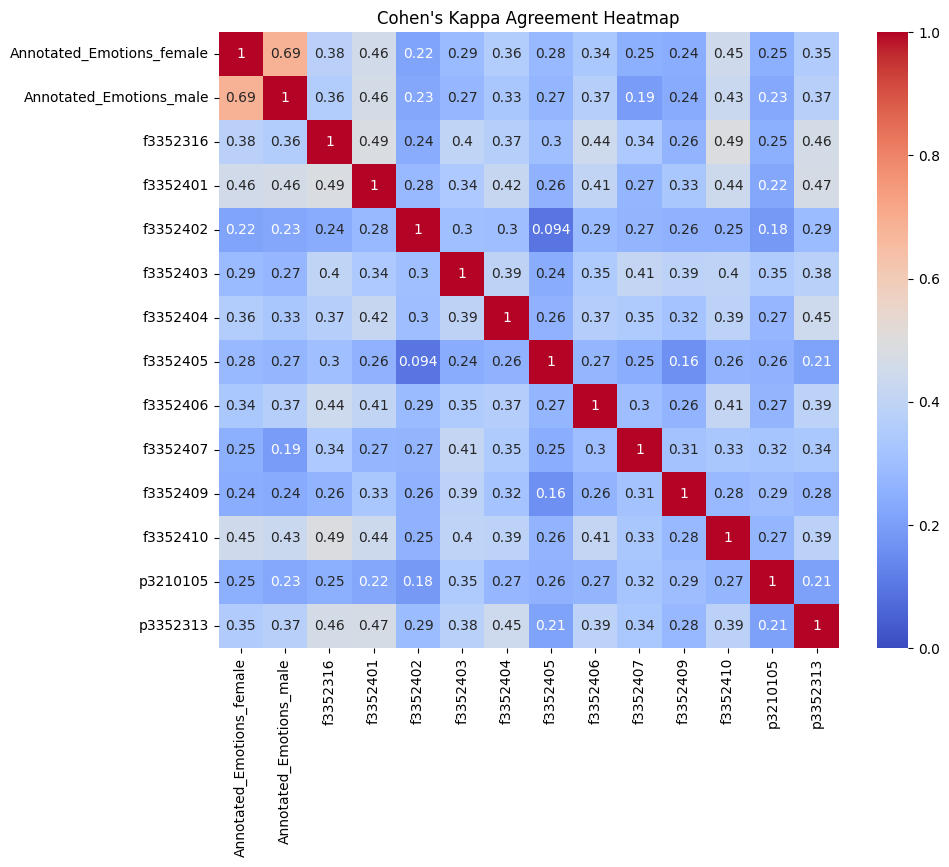

In [18]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import numpy as np

#  data and compute pairwise agreement
annotator_data = {}  # Dictionary to load each Excel file into for each annotator

#  through files in the specified folder
for file in os.listdir(folder_path):
    # Check if the file is an Excel file
    if file.endswith('.xlsx'):
        # Extract annotator ID from the filename
        annotator_id = file.split('.')[0]
        # Load the relevant columns from the Excel file into a DataFrame
        df = pd.read_excel(os.path.join(folder_path, file), header=1)
        annotator_data[annotator_id] = df[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

#  DataFrames to store pairwise kappa and percentage agreements
annotators = list(annotator_data.keys())
pairwise_kappa = pd.DataFrame(index=annotators, columns=annotators)  # Kappa scores matrix
pairwise_percentage = pd.DataFrame(index=annotators, columns=annotators)  # Percentage agreement matrix

#  pairwise agreements for each pair of annotators
for i in range(len(annotators)):
    for j in range(i, len(annotators)):
        annotator1 = annotators[i]
        annotator2 = annotators[j]

        """
        In our dataset, there are some missing values eg. 
        (file f3352404 cell f56 ,file f3352404 file f3352406 row 60)
        """
        data1 = annotator_data[annotator1]  # Data for the first annotator
        data1 = data1.fillna(0)  # Replace NaN values with 0
        data2 = annotator_data[annotator2]  # Data for the second annotator
        data2 = data2.fillna(0)  # Replace NaN values with 0
        
        # Calculate Percentage Agreement
        # Count the number of agreements for each emotion
        agree_counts = (data1.values == data2.values).sum(axis=1)  # Count of agreements per emotion
        total_counts = data1.shape[1]  # Total number of emotions
        # Compute the mean percentage agreement
        percentage_agreement = (agree_counts == total_counts).mean()  
        # Store the percentage agreement results symmetrically in the DataFrame
        pairwise_percentage.loc[annotator1, annotator2] = percentage_agreement
        pairwise_percentage.loc[annotator2, annotator1] = percentage_agreement

        # Calculate Cohen's Kappa for the emotions
        # Compute kappa scores for each emotion and average them
        kappa_scores = [cohen_kappa_score(data1[emotion], data2[emotion]) for emotion in data1.columns]
        avg_kappa = sum(kappa_scores) / len(kappa_scores)  # Average kappa score
        # Store the average kappa results symmetrically in the DataFrame
        pairwise_kappa.loc[annotator1, annotator2] = avg_kappa
        pairwise_kappa.loc[annotator2, annotator1] = avg_kappa

#  kappa and percentage agreement  to float for better display
pairwise_kappa = pairwise_kappa.astype(float)
pairwise_percentage = pairwise_percentage.astype(float)

# saverage scores for kappa and percentage agreement
avg_kappa = pairwise_kappa.values.mean()  # Average Kappa score across all pairs
avg_percentage = pairwise_percentage.values.mean()  # Average percentage agreement across all pairs
print(f"Average Kappa is: {round(avg_kappa, 2)} Average percentage is: {round(avg_percentage, 2)}")

# Heatmap for Cohen's Kappa agreement
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_kappa, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title('Cohen\'s Kappa Agreement Heatmap')
plt.show()




The diagonal cells, where each annotator is compared to themselves, naturally show a perfect score of 1, reflecting self-consistency. Moving off the diagonal, we see a range of Kappa scores between pairs of annotators. Notably, the highest agreement (0.69) is observed between Annotated_Emotions_female and Annotated_Emotions_male, suggesting these two annotators have similar standards or criteria when interpreting emotional data which is quite possible as they were produced by the same LLM

Other pairs, like Annotated_Emotions_female with f3352401, also show relatively high Kappa scores, which could imply closer alignment in annotation styles.

However, there are areas where agreement is considerably lower, highlighted by lighter blue cells. For instance, annotators such as f3352402 with others frequently display scores around 0.2-0.3, suggesting they interpret emotions differently from their peers. This variability could signal the need for clearer annotation guidelines or training, especially for annotators with consistently low scores.

Overall, the average Kappa score of 0.37 indicates moderate agreement across annotators, while an average agreement percentage of 31% suggests that annotators only agreed on around one-third of the cases. 

# Per Emotion Inter Annotation Agreement between Agents and Humand Annotators

Average Kappa per emotion: {'Anger': 0.35, 'Fear': 0.33, 'Joy': 0.49, 'Sadness': 0.39, 'Surprise': 0.33}
Average Percentage Agreement per emotion: {'Anger': 0.79, 'Fear': 0.75, 'Joy': 0.85, 'Sadness': 0.71, 'Surprise': 0.74}


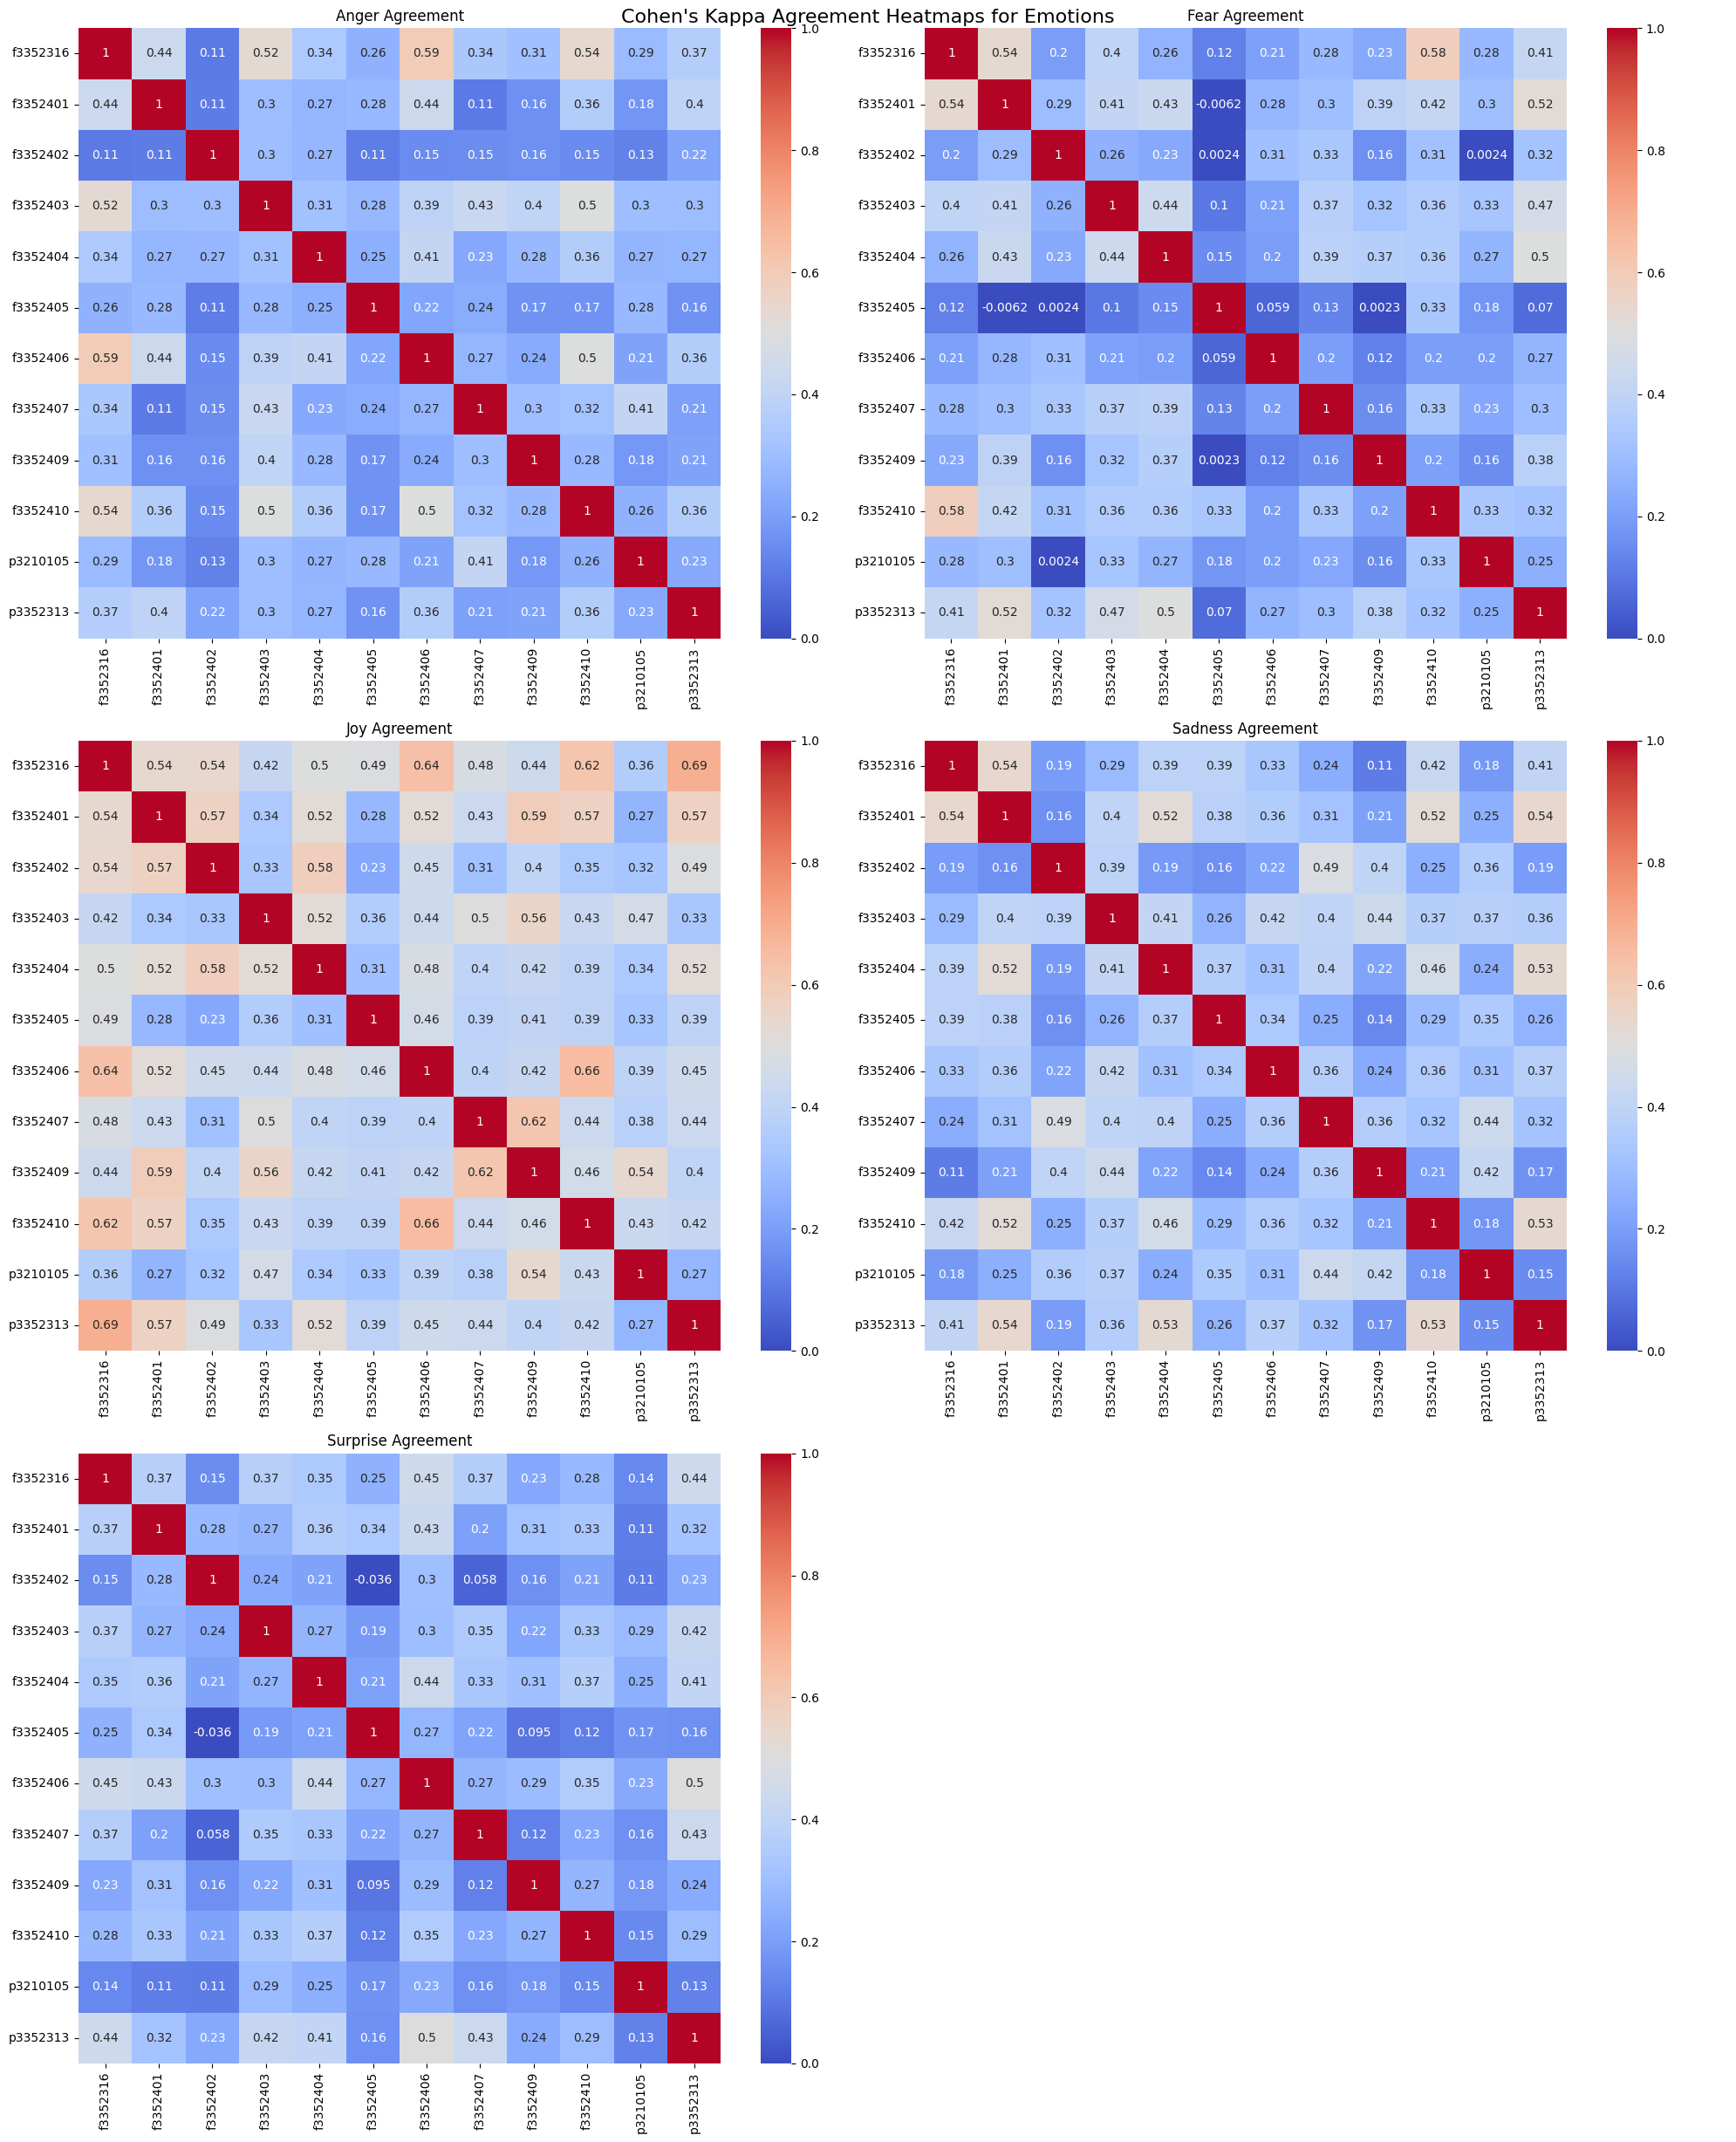

In [41]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# Specify the folder path containing the Excel files

# Dictionary to load each Excel file into for each annotator
annotator_data = {}

# Iterate through files in the specified folder
for file in os.listdir(folder_path):
    if file.endswith('.xlsx'):
        annotator_id = file.split('.')[0]  # Extract annotator ID from the filename
        df = pd.read_excel(os.path.join(folder_path, file), header=1)
        annotator_data[annotator_id] = df[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

# Dictionaries to store pairwise results for each emotion
pairwise_kappa_per_emotion = {emotion: pd.DataFrame(index=annotator_data.keys(), columns=annotator_data.keys()) 
                              for emotion in annotator_data[next(iter(annotator_data))].columns}
pairwise_percentage_per_emotion = {emotion: pd.DataFrame(index=annotator_data.keys(), columns=annotator_data.keys()) 
                                   for emotion in annotator_data[next(iter(annotator_data))].columns}

# List of annotator IDs for iterating through pairs
annotators = list(annotator_data.keys())
for i in range(len(annotators)):
    for j in range(i, len(annotators)):
        annotator1 = annotators[i]
        annotator2 = annotators[j]

        # Fill null values with zero in data from each annotator
        data1 = annotator_data[annotator1].fillna(0)
        data2 = annotator_data[annotator2].fillna(0)

        for emotion in data1.columns:
            # Percentage Agreement for the current emotion
            percentage_agreement = (data1[emotion].values == data2[emotion].values).mean()
            pairwise_percentage_per_emotion[emotion].loc[annotator1, annotator2] = percentage_agreement
            pairwise_percentage_per_emotion[emotion].loc[annotator2, annotator1] = percentage_agreement

            # Cohen's Kappa for the current emotion
            kappa_score = cohen_kappa_score(data1[emotion], data2[emotion])
            pairwise_kappa_per_emotion[emotion].loc[annotator1, annotator2] = kappa_score
            pairwise_kappa_per_emotion[emotion].loc[annotator2, annotator1] = kappa_score

# Convert metrics to float for better display in visualization
for emotion in pairwise_kappa_per_emotion:
    pairwise_kappa_per_emotion[emotion] = pairwise_kappa_per_emotion[emotion].astype(float)
    pairwise_percentage_per_emotion[emotion] = pairwise_percentage_per_emotion[emotion].astype(float)

# Calculate and print overall averages for Kappa and Percentage Agreement per emotion
avg_kappa = {emotion: float(pairwise_kappa_per_emotion[emotion].values.mean()) for emotion in pairwise_kappa_per_emotion}
avg_percentage = {emotion: float(pairwise_percentage_per_emotion[emotion].values.mean()) for emotion in pairwise_percentage_per_emotion}

print("Average Kappa per emotion:", {emotion: round(score, 2) for emotion, score in avg_kappa.items()})
print("Average Percentage Agreement per emotion:", {emotion: round(score, 2) for emotion, score in avg_percentage.items()})


fig, axes = plt.subplots(3, 2, figsize=(20,25))
fig.suptitle("Cohen's Kappa Agreement Heatmaps for Emotions", fontsize=16)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each emotion's heatmap
for i, (emotion, heatmap_data) in enumerate(pairwise_kappa_per_emotion.items()):
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(f'{emotion} Agreement')

# Hide any unused subplots (if fewer than 9 emotions)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust layout to fit the main title
plt.show()



## General Observations:
**High Internal Consistency:**

For each emotion, the kappa agreement between the female and male agent annotators' scores (e.g., Annotated_Emotions_female and Annotated_Emotions_male) is quite high, indicating good internal consistency in emotion annotation within each gender group. For example:
 1. Anger: 0.738739
 2. Fear: 0.652991
 3. Joy: 0.775889

**Variability Among Other Annotators:**

The kappa scores for other annotators (e.g., f3352316, f3352401, etc.) with the male and female annotated emotions show variability. For instance:
In Anger, the lowest kappa among the human annotators (e.g., f3352402, f3352404) are 0.111712 and 0.213855, respectively.
In Fear, scores like 0.180312 and 0.144182 indicate a lower alignment with the gendered annotations.
In Joy, most scores are higher than in Anger and Fear, with several annotators showing strong kappas (e.g., f3352401 with 0.653473).

**Conclusions:**


Both male and female agent annotators show consistent ratings for emotions. This suggests that their understanding and interpretation of emotional content in the dataset are aligned, particularly for "Joy," which has the highest correlation.

The lower correlations for "Fear" and "Anger" compared to "Joy" could indicate that annotators might be more sensitive or have differing thresholds for detecting positive emotions versus negative emotions. 

The variability among other annotators suggests that not all annotators share the same perspective on emotional content. Some annotators might have unique biases or styles that affect how they perceive emotions in the texts.